# View DC2 data organisation in tracts and patches

from the LSSTC community https://community.lsst.org/t/how-to-make-a-loop-over-tracts-and-patches-to-split-the-dc2-dataset/6081/3

In [1]:
from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

In [43]:
# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import lsst.afw.coord as afwCoord
afwDisplay.setDefaultBackend('matplotlib')

#
from lsst import skymap


In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [8]:
import numpy as np

In [2]:
results = service.search("select tract,patch,min(ra) as minRA, max(ra) as maxRA, min(dec) as minDec, max(dec) as maxDec,count(*) as num \
                          from dp01_dc2_catalogs.object group by tract,patch")
results_tab = results.to_table()

In [12]:
results_tab

tract,patch,minRA,maxRA,minDec,maxDec,num
int64,str3,float64,float64,float64,float64,int64
2723,"0,6",50.9184345,50.9379244,-44.6297682,-44.6284536,2
2723,"1,6",50.4329392,50.6769141,-44.6393502,-44.6281647,31
2723,"2,6",50.1200333,50.3095179,-44.634863,-44.628641,21
2723,"3,6",49.7877033,50.0171863,-44.642279,-44.6282091,23
2723,"4,6",49.751747,49.7857281,-44.6387177,-44.6285689,21
2724,"0,6",52.8085414,53.0630551,-44.6428536,-44.6282163,60
2724,"1,6",52.4940349,52.7556174,-44.6430477,-44.6281783,25
2724,"2,6",52.2607324,52.4910255,-44.6390512,-44.6281483,48
2724,"3,6",51.8692502,52.0679554,-44.6360238,-44.6281112,18


In [4]:
ll=results_tab['minRA','minDec'].as_array()
ul=results_tab['minRA','maxDec'].as_array()
ur=results_tab['maxRA','maxDec'].as_array()
lr=results_tab['maxRA','minDec'].as_array()
counts=results_tab['num']

(-47.0, -25.0)

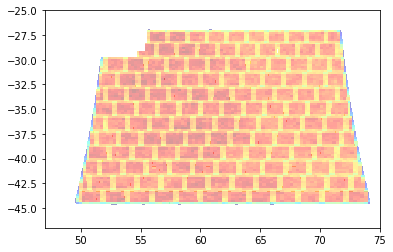

In [9]:
fig, ax = plt.subplots()
patches = []
num_polygons = len(results_tab)
num_sides = 4
for i in range(num_polygons):
    corners = np.array([ ( ll[i][0], ll[i][1]), (ul[i][0], ul[i][1] ), (ur[i][0], ur[i][1]), (lr[i][0], lr[i][1])  ])
    polygon = Polygon(corners,True)
    patches.append(polygon)
p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
p.set_array(np.array(counts))
ax.add_collection(p)  
plt.xlim([47, 75])
plt.ylim([-47, -25])

In [26]:
query_tracts = "select distinct tract from dp01_dc2_catalogs.object order by tract ASC"

In [36]:
results_tracts = service.search(query_tracts)
results_tracts = results_tracts.to_table().to_pandas()

In [38]:
results_tracts

,tract
0,2723
1,2724
2,2725
3,2726
4,2727
...,...
161,5070
162,5071
163,5072
164,5073


In [45]:
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = dafButler.Butler(repo,collections=collection)

In [46]:
skymap = butler.get('skyMap')

In [47]:
tract_list = results_tracts["tract"].values

8134


(-47.0, -25.0)

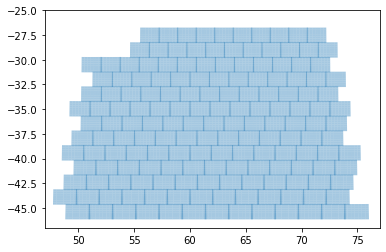

In [48]:

numTracts=0
patches = []
for tractID in tract_list:
    for tractInfo in skymap:
        if tractInfo.getId() == tractID:
           # print(tractID)
            for patch in tractInfo:
                numTracts+=1
                #print(patch)
                ibb=patch.getInnerBBox()
                tWCS=tractInfo.getWcs()
                corners = []
                for corner in ibb.getCorners():
                    p = geom.Point2D(corner.getX(), corner.getY())
                    coord = tWCS.pixelToSky(p)
                    corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
                #print(corners)
                polygon = Polygon(corners,True)
                patches.append(polygon)
print(numTracts)
fig, ax = plt.subplots()
p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
ax.add_collection(p)  
plt.xlim([47, 77])
plt.ylim([-47, -25])


